## 1 Introduction

### 1.1 Introduction

The project aims at examining past data of a micro finance about their customer profile and their payment credentials. Further, the organization has also given the cost of acquiring a single customer and estimated value they get from the customer. Using this information, we will develop an algorithm that will take customer profile and generate a credit score and also balancing on risk and return, the model will give direction on whether to approve or otherwise.

### 1.2 Objectives 

We need to 
1. Create a credit rating scoring algorithm
2. Determine the optimal credit score for approval

### 1.3 The Data

Used data sourced from Kaggle https://www.kaggle.com/datasets/kapturovalexander/bank-credit-scoring/bank.csv


This data was provided for bank credit scoring project but we decided to adopt it to our scenario to show how we were able to help a Microfinance client with similar problem and having data which closely matches to this dataset

### 1.4  Libraries 

In [1]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import joblib
import random


import warnings
warnings.filterwarnings("ignore")

## 2.0 The Data 

### 2.1 Import data 

In [2]:
df = pd.read_csv("bank.csv", sep=';')

### 2.1 Seeking to understand data 

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
df.shape

(4521, 17)

In [5]:
df.duplicated().sum()

0

Good, no duplicates in this data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


data has only 2 feature types; **int64** and **object**

In [7]:
df.nunique()

age            67
job            12
marital         3
education       4
default         2
balance      2353
housing         2
loan            2
contact         3
day            31
month          12
duration      875
campaign       32
pdays         292
previous       24
poutcome        4
y               2
dtype: int64

There are a few columns few unique values, lets delve deep into them and see their values

In [8]:
for col in df:
    if df[col].nunique() <=4 :
        print(f'{col} uniques: {df[col].unique()}')

marital uniques: ['married' 'single' 'divorced']
education uniques: ['primary' 'secondary' 'tertiary' 'unknown']
default uniques: ['no' 'yes']
housing uniques: ['no' 'yes']
loan uniques: ['no' 'yes']
contact uniques: ['cellular' 'unknown' 'telephone']
poutcome uniques: ['unknown' 'failure' 'other' 'success']
y uniques: ['no' 'yes']


In [9]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Good, this data is complete, no NULL values. It saves good amount of time

In [10]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


1. For all columns, there are 4521 records
2. None of features has a constant value (Min NOT equal to Max).
3. **balance** column have minimum value which is negative

In [11]:
# a function to check outliers

def count_outliers(df):
    # Calculate Q1, Q3, and IQR for each column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers for each column
    outliers = ((df < lower_bound) | (df > upper_bound))

    # Count outliers for each column
    num_outliers = outliers.sum()

    return num_outliers

In [12]:
#Identify outliers in the data

df_outliers_count = count_outliers(df)

# Print the number of outliers per column
df_outliers_count.to_frame().T

,age,balance,campaign,contact,day,default,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous,y
0,38,506,318,0,0,0,330,0,0,0,0,0,0,816,0,816,0


It is clear the data has notable instances of outliers in 6 columns

So, outlier_columns = ['age', 'balance', 'campaign', 'duration', 'pdays', 'previous']

### 2.3 Feature Engineering 

In [21]:
data = df.copy()

#### 2.3.1 Label encoding 

In [22]:
data['education'].replace({'primary':0, 'secondary': 1, 'tertiary': 3, 'unknown': 3  }, inplace =True)
data['month'].replace({'jan':0, 'feb': 1, 'mar': 2, 
            'apr': 3, 'may': 4, 'jun': 5 , 
            'jul': 6 , 'aug': 7 , 'sep': 8, 
            'oct': 9 , 'nov': 10 , 'dec': 11 }, inplace =True)

data['job'].replace({'student':0, 'success': 1, 'other': 0, 'unknown':1 }, inplace =True)
data['job'].replace({'unemployed':0, 'services':1, 
                   'management':1, 'blue-collar':1, 
                   'self-employed':1, 'technician':1,
                   'entrepreneur':1, 'admin.':1,
                   'student':0, 'housemaid':1,
                   'retired':0, 'unknown': 1}, inplace =True)

data['marital'].replace({'single':0, 'married': 1, 'divorced': 0 }, inplace =True)

data['contact'].replace({'cellular':0, 'telephone': 1, 'unknown': 3 }, inplace =True)
data['poutcome'].replace({'failure':0, 'success': 1, 'other': 1, 'unknown':0 }, inplace =True)

In [23]:
data.replace({'yes':1, 'no': 0}, inplace =True)

In [24]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,0,1,0,0,1787,0,0,0,19,9,79,1,-1,0,0,0
1,33,1,1,1,0,4789,1,1,0,11,4,220,1,339,4,0,0
2,35,1,0,3,0,1350,1,0,0,16,3,185,1,330,1,0,0
3,30,1,1,3,0,1476,1,1,3,3,5,199,4,-1,0,0,0
4,59,1,1,1,0,0,1,0,3,5,4,226,1,-1,0,0,0


#### 2.3.2 Scaling

Understanding that the data is in different ranges for all columns, it is important to scale the data before training. This process will be done after splitting Training and Testing datasets.

#### 2.3.3 Missing Value Imputation

No Missing value was identified in the data, so this process isnt necessary

#### 2.3.4 Outlier Treatment

In [25]:
data.nunique().T

age            67
job             2
marital         2
education       3
default         2
balance      2353
housing         2
loan            2
contact         3
day            31
month          12
duration      875
campaign       32
pdays         292
previous       24
poutcome        2
y               2
dtype: int64

In [26]:
#create a function to reset as follows:-
# 1. all UPPER outliers to Q3+1.5IQR
# 2. all LOWER outliers to Q1-1.5IQR
def reset_outliers(dataset, outlier_columns):
    # Create a copy of the DataFrame to avoid modifying the original
    dataset_cleaned =dataset.copy()

    # Iterate through each column in outlier_columns
    for col in outlier_columns:
        # Calculate Q1, Q3, and IQR for the current column
        Q1 = dataset_cleaned[col].quantile(0.25)
        Q3 = dataset_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Reset outliers to the bounds for the current column
        dataset_cleaned[col] = dataset_cleaned[col].clip(lower=lower_bound, upper=upper_bound)

    return dataset_cleaned



# Apply the function to our data
outlier_columns = ['age', 'balance', 'campaign','duration']
data = reset_outliers(dataset=data, outlier_columns = outlier_columns)

In [27]:
#Check whether outliers have been treated
df_outliers_count = count_outliers(data)

# Print the number of outliers per column
df_outliers_count.to_frame().T

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,442,0,0,76,0,0,691,0,0,0,0,0,816,816,326,521


Good, all outliers are now treated BUT our target variable remains as is. 

It will be treated before training

## 3.0 Exploratory Data Analysis 

### 3.1 Target / Output Feature 

<AxesSubplot: xlabel='y', ylabel='count'>

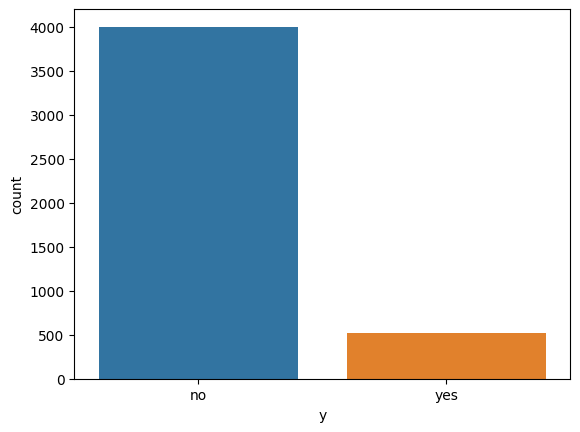

In [28]:
sns.countplot(x='y',data=df)

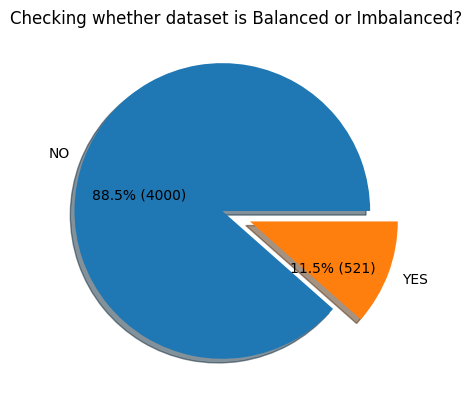

In [29]:
# Count the number of occurrences of each value in the 'price_range' column
classes = df['y'].value_counts()

# Create a pie chart with percentage values formatted with a % sign and explode the slices
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(classes.values, autopct='%0.1f%%', explode=[0.1, 0.1], shadow=True, labels=['NO', 'YES']) #, colors=colors)

# Add count under percentage
for i, autotext in enumerate(autotexts):
    count = classes[i]
    autotext.set_text(f'{autotext.get_text()} ({count})')
    autotext.set_y(autotext.get_position()[1]-0.1)

# Set the title of the pie chart
ax.set_title('Checking whether dataset is Balanced or Imbalanced?')

# Show the pie chart
plt.show()

Evident that we are working with imbalanced data.

### 3.2 Univariate Analysis 

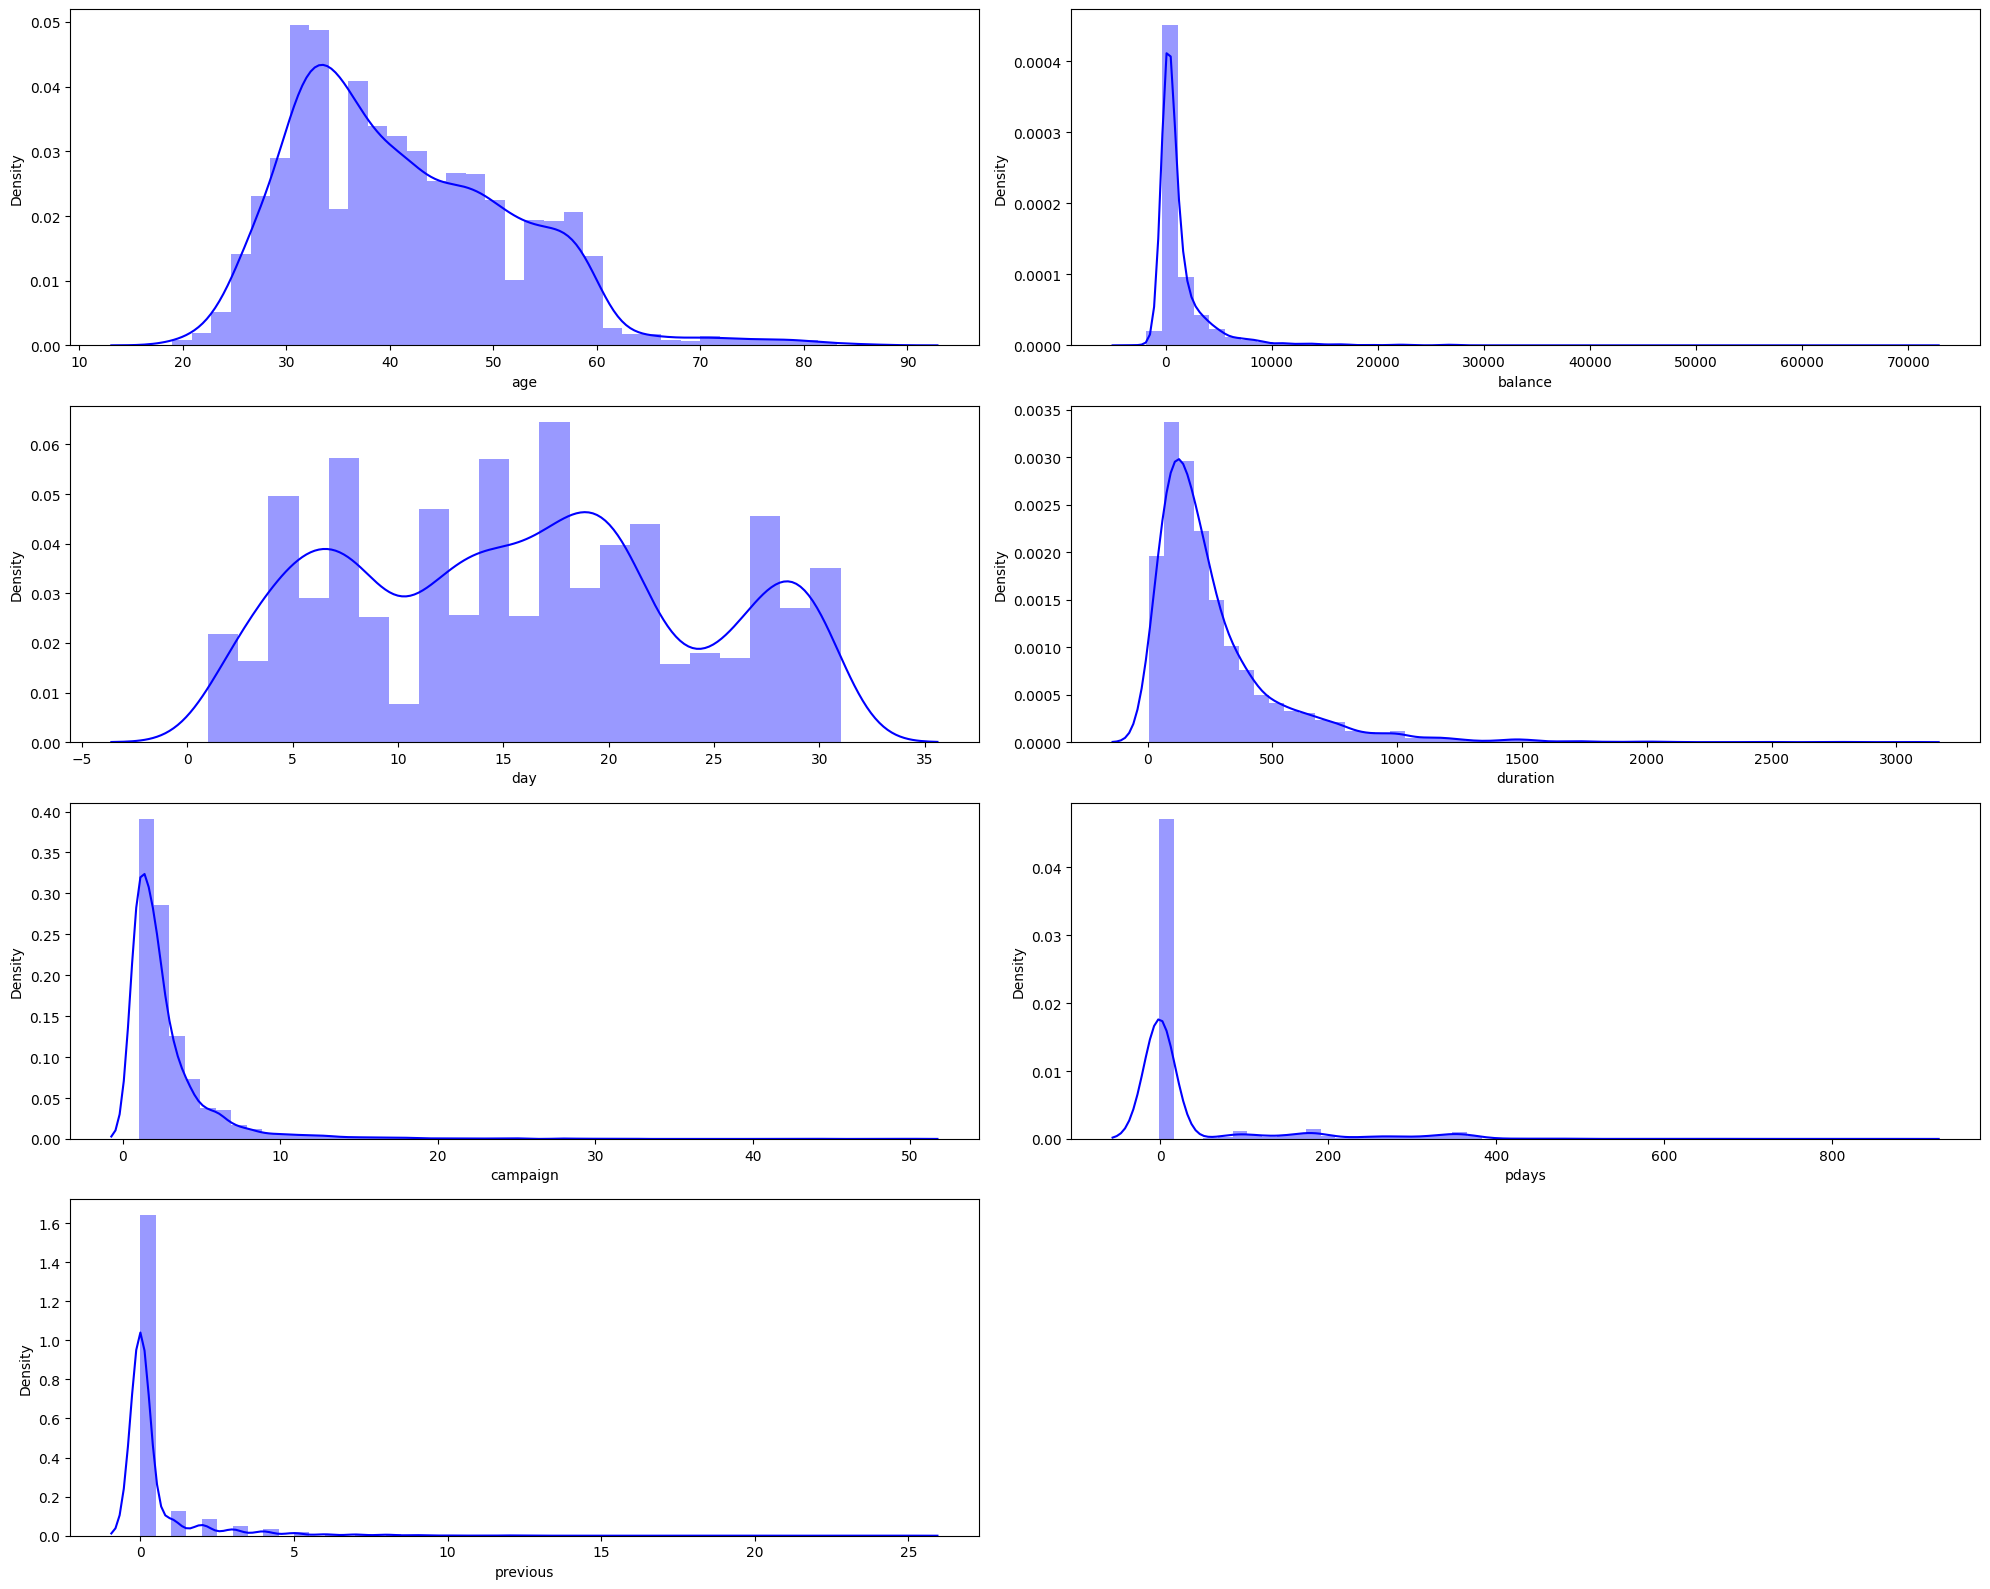

In [30]:
# Checking popularity of features in the market
    
numeric_variables = df.select_dtypes(include=['int64']).columns.tolist()


#create figure with subplots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,16))
axs = axs.flatten()

#create histogram for each Numeric variable
for i, var in enumerate(numeric_variables):
    #sns.histplot(data=df, x=var, kde=True, color='b', ax=axs[i])
     sns.distplot(df[var], color='b', ax=axs[i])
        
# Remove any empty subplot
if len(numeric_variables)<len(axs):
    for i in range(len(numeric_variables), len(axs)):
        fig.delaxes(axs[i])

    
#adjust spacing between subplots
fig.tight_layout()


#show plot
plt.show()

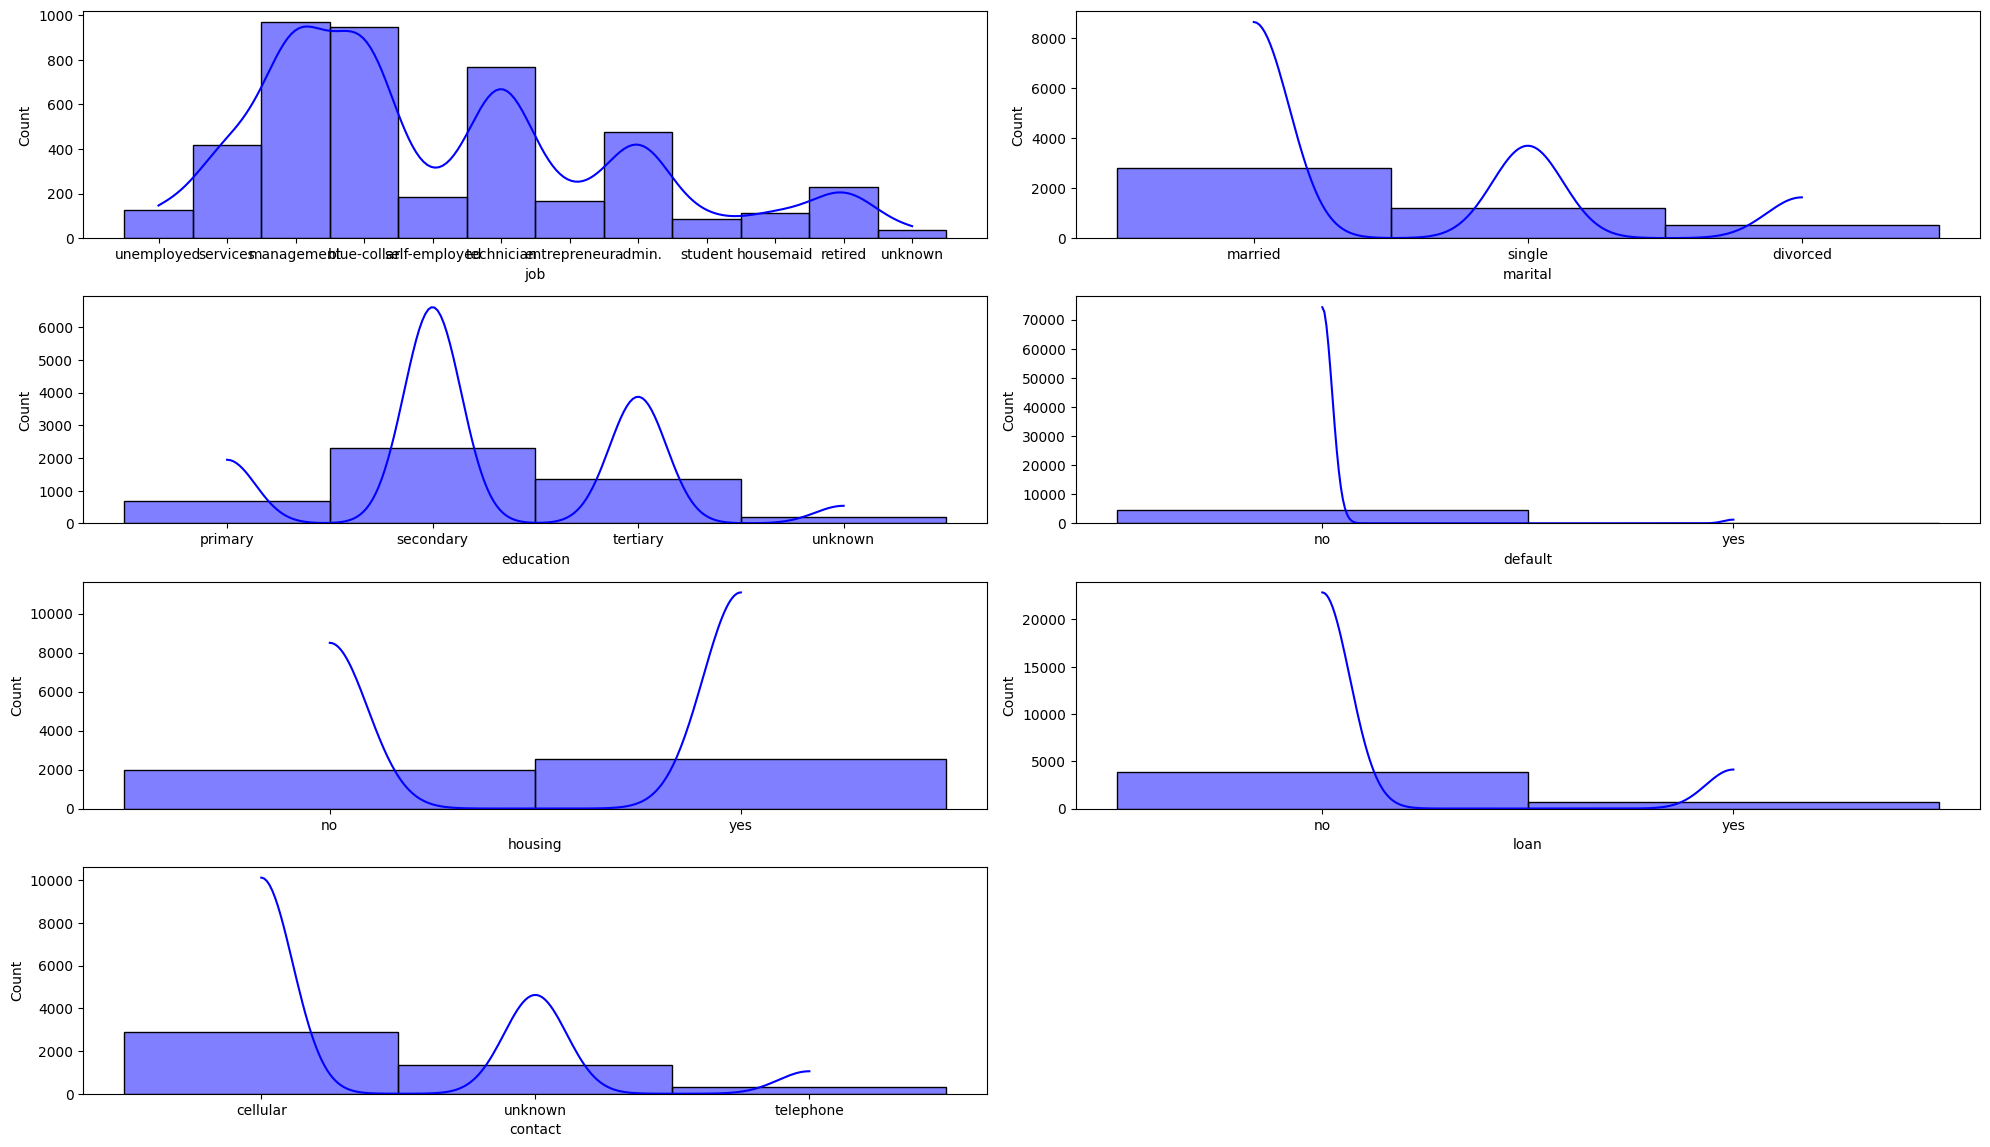

In [31]:
cate_variables = df.select_dtypes(include=['object']).columns.tolist()


#create figure with subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20,14))
axs = axs.flatten()

#create histogram for each Numeric variable
for i, var in enumerate(cate_variables):
    sns.histplot(data=df, x=var, kde=True, color='b', ax=axs[i])
      
# Remove any empty subplot
if len(numeric_variables)<len(axs):
    for i in range(len(numeric_variables), len(axs)):
        fig.delaxes(axs[i])

    
#adjust spacing between subplots
fig.tight_layout()


#show plot
plt.show()

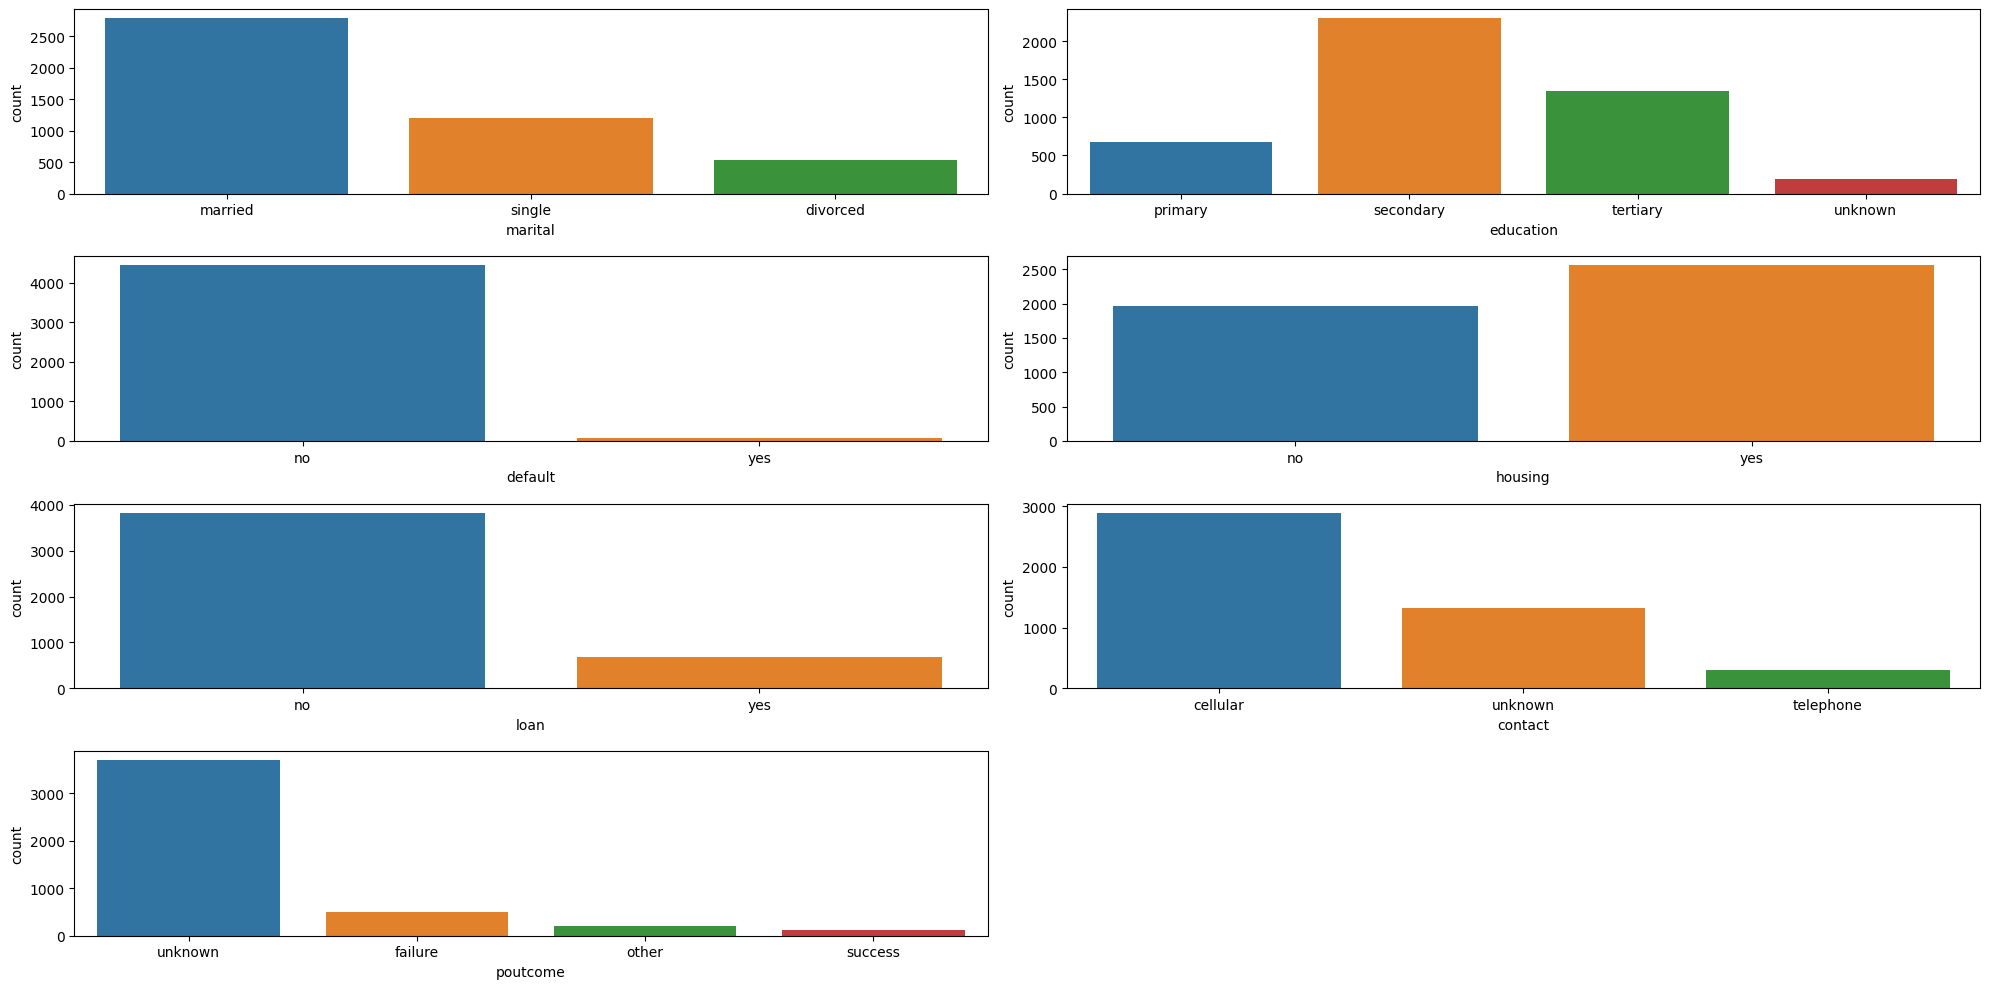

In [32]:
cate_cols=[]
for col in df:
    if df[col].nunique() <=4 :
        cate_cols.append(col)

        
        
#create figure with subplots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,10))
axs = axs.flatten()

#create histogram for each Numeric variable
for i, var in enumerate(cate_cols):
    sns.countplot(data=df, x=var, ax=axs[i])
    
     
# Remove any empty subplot
if len(numeric_variables)<len(axs):
    for i in range(len(numeric_variables), len(axs)):
        fig.delaxes(axs[i])

    
#adjust spacing between subplots
fig.tight_layout()


#show plot
plt.show()

### 3.3 Multivariate Analysis 

<Figure size 800x600 with 0 Axes>

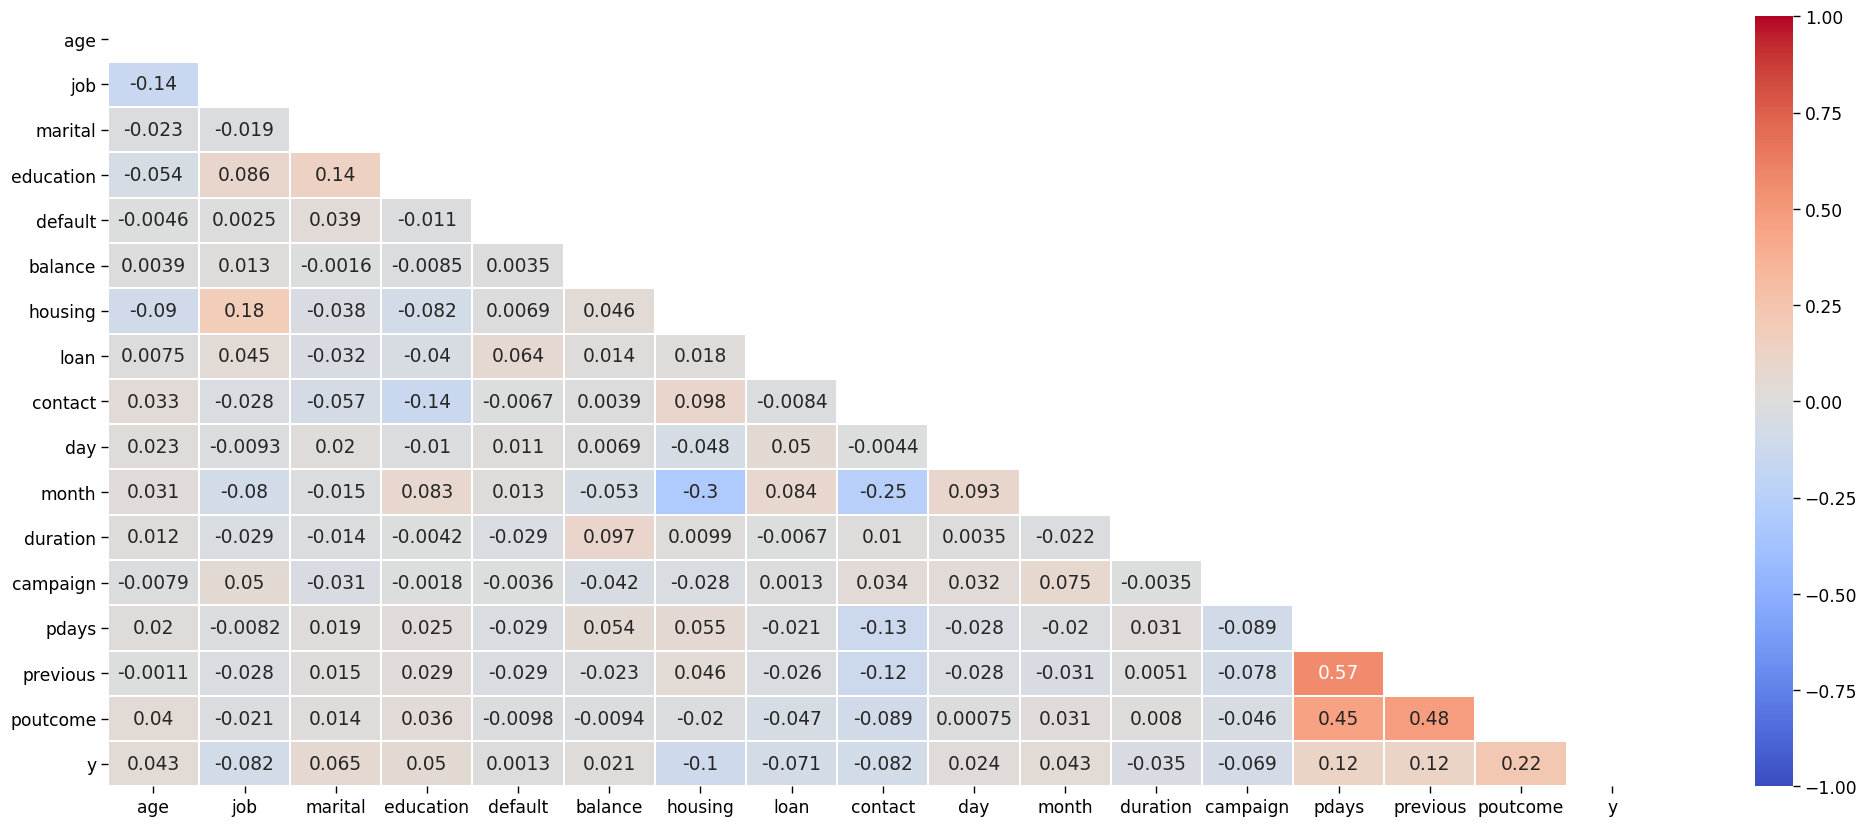

In [33]:
plt.figure(figsize=(8,6))
sns.set_context('paper',font_scale=1.4)

corr = data.apply(lambda x: pd.factorize(x)[0]).corr()


#Correlation Matrix
plt.figure(figsize=(25, 10))

mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, 
                 yticklabels=corr.columns, annot=True, 
                 linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [34]:
X=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

In [35]:
#Oversample minority

#Class count
count_class_0, count_class_1 = df.y.value_counts()

data_majority = data[data['y'] == 0]
data_minority = data[data['y'] == 1]

print(f'Minority class has {data_minority.shape[0]}  cases while majority has {data_majority.shape[0]} cases')

Minority class has 521  cases while majority has 4000 cases


In [36]:
data_minority_oversampled = data_minority.sample(count_class_0, replace=True)
new_data_minority_oversampled = pd.concat([data_majority, data_minority_oversampled], axis=0)
new_data_minority_oversampled['y'].value_counts()

0    4000
1    4000
Name: y, dtype: int64

In [37]:
#splitting to test and train data
X=new_data_minority_oversampled.iloc[:,:-1]
y=new_data_minority_oversampled.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, shuffle=True, random_state=100)

In [38]:
y_test.head()

3653    1
498     0
3458    1
1430    0
69      0
Name: y, dtype: int64

In [39]:
#Scale the data; this process was highlighted during Feature scaling section.
ms=MinMaxScaler()
X_train_scaled = ms.fit_transform(X_train)
X_test_scaled = ms.transform(X_test)

In [40]:
pickle.dump(ms, open('scaler.pkl', 'wb'))

In [41]:
#Exporting Normalisation Coefficients 
joblib.dump(ms, 'scaling_model')

['scaling_model']

## 4.0 Modelling 

### 4.1 Choice of Model 

Choice of model is based on my understanding of the structure of data
1. Imbalanced
2. Outliers in 6 columns
3. Outcomes required 
    - Probablilities 

**Logistic Regression** is appropriate but given it is sensitive to imbalance data, we needed to resolve for that by oversampling the minority class in above section

### 4.2 Base Model - Logistic Regression

In [42]:
lr = LogisticRegression()
lr.fit(X_train_scaled,y_train)
y_pred_lr=lr.predict(X_test_scaled)
accuracy_base = accuracy_score(y_test, y_pred_lr)
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       778
           1       0.83      0.80      0.82       822

    accuracy                           0.81      1600
   macro avg       0.81      0.81      0.81      1600
weighted avg       0.81      0.81      0.81      1600



### 4.3 Hyperparameter Optimization

In [43]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# define models and parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag','saga']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = np.logspace(-4,4, 50)
max_itr = [100, 120,150, 200]

#define grid search

grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=max_itr)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = RandomizedSearchCV(estimator=lr, param_distributions=grid, n_jobs=-1, cv=cv, n_iter=100, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.807292 using {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 120, 'C': 0.3906939937054613}
0.734292 (0.015977) with: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 120, 'C': 0.009102981779915217}
0.000000 (0.000000) with: {'solver': 'liblinear', 'penalty': 'none', 'max_iter': 120, 'C': 0.5689866029018293}
0.000000 (0.000000) with: {'solver': 'lbfgs', 'penalty': 'l1', 'max_iter': 150, 'C': 24.420530945486497}
0.000000 (0.000000) with: {'solver': 'newton-cg', 'penalty': 'elasticnet', 'max_iter': 150, 'C': 35.564803062231285}
0.805667 (0.014954) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 150, 'C': 7.9060432109076855}
0.000000 (0.000000) with: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 100, 'C': 0.00030888435964774815}
0.000000 (0.000000) with: {'solver': 'newton-cg', 'penalty': 'l1', 'max_iter': 200, 'C': 0.019306977288832496}
0.728750 (0.015609) with: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'C': 719.6856730011514}
0.000000 (0.000000)

In [44]:
grid_result.best_estimator_

LogisticRegression(C=0.3906939937054613, max_iter=120, solver='liblinear')

In [45]:
grid_result.best_params_

{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 120,
 'C': 0.3906939937054613}

In [46]:
grid_result.best_estimator_.fit(X_train_scaled,y_train)
y_pred_mdl=grid_result.best_estimator_.predict(X_test_scaled)
accuracy_optimized = accuracy_score(y_test, y_pred_mdl)
print(classification_report(y_test,y_pred_mdl))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       778
           1       0.83      0.81      0.82       822

    accuracy                           0.82      1600
   macro avg       0.82      0.82      0.82      1600
weighted avg       0.82      0.82      0.82      1600



In [47]:
#Determine the model to use; the one with best accuracy
model = lr #set base to be default model
if accuracy_optimized > accuracy_base:
    model = grid_result.best_estimator_ #if optimized model has better accuracy, then make it the default model
    

### 4.5 Apply trained Model to original Imbalanced data

In [48]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
X_new_train,X_new_test,y_new_train,y_new_test=train_test_split(X,y,test_size=0.2, shuffle=True, random_state=100)


y_new = model.predict(ms.transform(X))
print(classification_report(y,y_new))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      4000
           1       0.35      0.80      0.49       521

    accuracy                           0.81      4521
   macro avg       0.66      0.80      0.68      4521
weighted avg       0.90      0.81      0.84      4521



In [49]:
predictions = model.predict_proba(ms.transform(X))
predictions

array([[0.7392412 , 0.2607588 ],
       [0.78233922, 0.21766078],
       [0.61612429, 0.38387571],
       ...,
       [0.85428817, 0.14571183],
       [0.48423913, 0.51576087],
       [0.19684701, 0.80315299]])

In [50]:
predictions = model.predict_proba(ms.transform(X))


df_pred_prob = pd.DataFrame(predictions, columns=['prob_0', 'prob_1'])
df_pred_target = pd.DataFrame(model.predict(ms.transform(X)), columns = ['Predicted_Target'])
df_test = pd.DataFrame(y)
df_test.rename(columns={'y': 'Actual_Target'}, inplace=True)

dfx = pd.concat([df_test, df_pred_prob, df_pred_target], axis=1)
dfx['credit_score'] = round(dfx['prob_0']*1000,0)

dfx.to_csv('model_outcome.csv', sep='-', encoding='UTF-8')

Determination of optimal credit score explained from this point in excel **model_outcome.xlsx**

In [51]:
dfx.head()

,Actual_Target,prob_0,prob_1,Predicted_Target,credit_score
0,0,0.739241,0.260759,0,739.0
1,0,0.782339,0.217661,0,782.0
2,0,0.616124,0.383876,0,616.0
3,0,0.968633,0.031367,0,969.0
4,0,0.891708,0.108292,0,892.0


In [52]:
#Let us see whether our model would accurately predicts right PRICE_RANGE for randomly selected record in row = ROW
ROW = random.randint(0, 4521)

print(f'the Actual Class for randomly selected row number {ROW} is {data.iloc[ROW,:].y}')

the Actual Class for randomly selected row number 2180 is 0.0


In [53]:
data_row_values = data.iloc[ROW,:-1].values
reshaped_data = data_row_values.reshape(1,-1)
data_row_values_scaled = ms.transform(reshaped_data)
data_row_predicted_values = model.predict(data_row_values_scaled)
data_row_prob = pd.DataFrame(model.predict_proba(data_row_values_scaled))
print(f'Predicted Class relating to row {ROW} is {data_row_predicted_values} with CREDIT SCORE {round(1000*data_row_prob.iloc[0,0],0)}')


Predicted Class relating to row 2180 is [0] with CREDIT SCORE 908.0


In [54]:
# save model object using pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [55]:
# save the model to object
joblib.dump(model, 'scoring_model')

['scoring_model']

In [56]:
# Lets see how deployed model will work by loading it and applying it to data in above example

# load scaler
#scaler = joblib.load('scaling_model')
scaler = pickle.load(open('scaler.pkl', 'rb'))
# load the saved model
#score = joblib.load('scoring_model')
score = pickle.load(open('model.pkl', 'rb'))

In [57]:
# For data in ROW above
data_row_values = data.iloc[ROW,:-1].values
reshaped_data = data_row_values.reshape(1,-1) #Reshape
data_row_values_scaled = scaler.transform(reshaped_data) #using Loaded scaler


# use the loaded model to make predictions
data_row_prob = pd.DataFrame(score.predict_proba(data_row_values_scaled)) #use loaded score


decision = 'Fail to Award, take file to supervisor for approval'
if 1000*data_row_prob.iloc[0,0]>=566:
    decision='Award Loan'
    


print(f'CREDIT SCORE {round(1000*data_row_prob.iloc[0,0],0)}, DECISION: {decision}')



CREDIT SCORE 908.0, DECISION: Award Loan


In [58]:
# When we deploying, the data needs to come in the following order
# when setting up inputs, consider below MIN and MAX values
columns = data.iloc[:,:-1].columns
for col in columns:
    print(f'{col} Min: {data[col].min()}, Max: {data[col].max()}')

age Min: 19, Max: 73
job Min: 0, Max: 1
marital Min: 0, Max: 1
education Min: 0, Max: 3
default Min: 0, Max: 1
balance Min: -2047.5, Max: 3596.5
housing Min: 0, Max: 1
loan Min: 0, Max: 1
contact Min: 0, Max: 3
day Min: 1, Max: 31
month Min: 0, Max: 11
duration Min: 4.0, Max: 666.5
campaign Min: 1, Max: 6
pdays Min: -1, Max: 871
previous Min: 0, Max: 25
poutcome Min: 0, Max: 1


In [59]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')